In [5]:
import pandas as pd
import numpy as np
from sklearn import model_selection,metrics
from tqdm import tqdm_notebook
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import deepdish as dd

import gc
import os
import logging
import datetime
import warnings
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import random
import pickle

In [6]:
os.listdir('/home/fshare_rb/rb/CAR/plans_new/')

['CAR_external.h5',
 'CAR_hard.h5',
 'CAR_hcc.h5',
 'CAR_odkp.h5',
 'CAR_with_names_and_preds.h5']

In [28]:
# Загрузка данных
CAR = dd.io.load('/home/fshare_rb/rb/CAR/plans_new/CAR_hard.h5')

In [29]:
# проверка размера
CAR.shape

(1179053, 160)

In [17]:
stcols = CAR.columns[CAR.columns.str.startswith('20')]

In [19]:
CAR= CAR[CAR.date<'2018-12-01']
CAR.shape

(100000, 160)

In [20]:
# выберем таргет колонку
target_cols = CAR.columns[CAR.columns.str.contains('coll_ov_\d')]
target_cols

Index(['coll_ov_30', 'coll_ov_30_num', 'coll_ov_90', 'coll_ov_90_num'], dtype='object')

In [21]:
"""
праметры LGBM модели для регрессии и классификации
"""

param_cls = {
    'lambda_l1': 5,
    'lambda_l2': 3,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'boost_from_average':False,
    'boost': 'gbdt',
    'feature_fraction': 0.7,
    'learning_rate': 0.01,
    'max_depth': 16,
#     'metric':'r2_score_lgbm',
    'metric':'auc',
    'min_data_in_leaf':100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 25,
    'num_threads': 10,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1,
    'unbalanced':True,
}



param_reg= {
    'lambda_l1': 5,
    'lambda_l2': 3,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'boost_from_average':False,
    'boost': 'gbdt',
    'feature_fraction': 0.7,
    'learning_rate': 0.001,
    'max_depth': 14,
#     'metric':'rmse',
#     'metric':'auc',
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 30,
    'num_threads': 12,
    'tree_learner': 'serial',
#     'objective': 'binary',
    'verbosity': 1,
#     'unbalanced':True,
}


In [22]:
# создаем список фичей
debt_cols= list(CAR.columns[CAR.columns.str.startswith('PT')])
non_feat = ['ac13_orig','ptdtn','ac13','date', 'delay_beg', 'id_cl','dpd_bucket','VAR_bucket','HUB','pmt_exec_date','coll_total']
features = [c for c in CAR.columns if c not in debt_cols+ non_feat+list(stcols)+list(target_cols)+['target']]

In [23]:
CAR.date = pd.to_datetime(CAR.date)
# dates = pd.date_range(start='2017-10-01',end='2018-11-01',freq='M')

In [24]:
dates = pd.date_range(start='2017-10-01',end='2018-11-01',freq='M')

In [25]:
dates

DatetimeIndex(['2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
"""
Функция новой метрики MAAPE, за счет использвования arctan в некоторых случаях работает лучше
"""

EPSILON = 1e-10

def maape( predicted,actual):

    actual = actual.get_label()

    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100

    """
    return 'myloss',np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON)))), False


In [30]:
target_col = 'coll_ov_30_num'

results_dict = {}
mapes = []
mapes_cbr = []

prev_date = None
for date in dates:
    date = pd.to_datetime(date)
    result_dict = {}
    date = date + pd.Timedelta(days=1)
    #filtering CAR parts
#     
#     if prev_date == None:
#         prev_date = date
#         continue
    print('\n ==================================== \n')
    
    CAR['target'] = CAR[target_col].fillna(0)
    CAR.target = (CAR.target>1000).astype(int)
    train_df_cls = CAR[CAR.date<date]
    test_df_cls = CAR[CAR.date==date]
    print(train_df_cls.shape,test_df_cls.shape)
    print('Date: {},Train shape: {}, test shape: {}'.format(str(date)[:10],train_df_cls.shape,test_df_cls.shape))
    
    
    #classification 
    predictions_cls = np.zeros(len(test_df_cls))
    trn_data = lgb.Dataset(train_df_cls[features], label=train_df_cls.target.values)
    val_data = lgb.Dataset(test_df_cls[features], label=test_df_cls.target.values)
    num_round = 50000
    clf_cls = lgb.train(param_cls, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 2000)
    
    fold_importance_df_cls = pd.DataFrame()
    fold_importance_df_cls["Feature"] = features
    fold_importance_df_cls["importance"] = clf_cls.feature_importance()
    predictions_cls = clf_cls.predict(test_df_cls[features], num_iteration=clf_cls.best_iteration)
    
    print('===========================')
    print("{} ROC AUC score: {:<8.5f}".format(str(date)[:10],metrics.roc_auc_score(test_df_cls.target.values, 
                                                                                   predictions_cls)))
    print('===========================')
    
    #regression 
    CAR['target'] = CAR[target_col].fillna(0)
    CAR.target = CAR.target/CAR.ptsum
    CAR[(CAR.target<=0)].target = 0
    CAR[(CAR.target>1.1)].target = 1
    CAR.target = CAR.target*100000
    CAR.shape

    train_df_reg = CAR[(CAR.date<date)&
                  (CAR.target>0)]
    test_df_reg =  CAR[(CAR.date==date)&
                  (CAR.target>0)]
    
    predictions_reg = np.zeros(len(test_df_reg))
    trn_data = lgb.Dataset(train_df_reg[features], label=train_df_reg.target.values)
    val_data = lgb.Dataset(test_df_reg[features], label=test_df_reg.target.values)
    clf_reg = lgb.train(param_reg, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 1000)#,feval=maape) # drop comment for use new metric
    fold_importance_df_reg = pd.DataFrame()
    fold_importance_df_reg["Feature"] = features
    fold_importance_df_reg["importance"] = clf_reg.feature_importance()
    predictions_reg = clf_reg.predict(test_df_reg[features], num_iteration=clf_reg.best_iteration)
    print('===========================')
    print("{} RMSE score: {:<8.5f}".format(str(date)[:10],
                                           np.sqrt(metrics.mean_squared_error(test_df_reg.target.values, predictions_reg))))
    print('===========================')
    
    
    # RESULTS
    test_df_cls['pred_reg'] = clf_reg.predict(test_df_cls[features],num_iteration=clf_reg.best_iteration)
    test_df_cls['pred_reg'] = test_df_cls['pred_reg']*test_df_cls.ptsum/100000
    test_df_cls['prob'] = predictions_cls
    test_df_cls['pred_reg_times_prob'] = test_df_cls['pred_reg']*test_df_cls['prob']
    result = test_df_cls.merge(test_df_reg[['ac13_orig','ptdtn','date']],
                        on=['ac13_orig','ptdtn','date'],how='left')
    result[result[target_col]<0][target_col] = 0
    
    fact = result[target_col].sum()
    predictions = result.pred_reg_times_prob.sum()
    mape = np.abs(fact-predictions)*100/fact
    mapes.append(mape)

    
    print('\n++++++++++++++++++++++++++++++++++')
    print('{} MAPE: {}'.format(str(date)[:10],mape))
    print('Cumulative MAPE: {}'.format(np.mean(mapes)))
    print('++++++++++++++++++++++++++++++++++++')
    
    result_dict['index'] = test_df_cls.index
    result_dict['fact'] = result[target_col].fillna(0)
    result_dict['pred_reg'] = test_df_cls['pred_reg']
    result_dict['prob'] = test_df_cls['prob']
    result_dict['predictions'] = result.pred_reg_times_prob
    result_dict['mape'] = mape
    
    results_dict[str(date)[:10]] = result_dict
    
    model_name = 'Hard_new' + '_results_dict_month_sep.pickle'
    
    with open(model_name, 'wb') as f:
        pickle.dump(results_dict,f)

        
        



(700442, 161) (38433, 161)
Date: 2017-11-01,Train shape: (700442, 161), test shape: (38433, 161)
Training until validation scores don't improve for 2000 rounds.


KeyboardInterrupt: 

# 3 M

In [45]:
param_cls = {
    'lambda_l1': 3,
    'lambda_l2': 3,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'boost_from_average':False,
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'learning_rate': 0.1,
    'max_depth': 15,
#     'metric':'r2_score_lgbm',
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 25,
    'num_threads': 10,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1,
    'unbalanced':True,
}



param_reg= {
    'lambda_l1': 3,
    'lambda_l2': 3,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'boost_from_average':False,
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'learning_rate': 0.1,
    'max_depth': 14,
    'metric':'rmse',
#     'metric':'auc',
    'min_data_in_leaf': 200,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 30,
    'num_threads': 8,
    'tree_learner': 'serial',
#     'objective': 'binary',
    'verbosity': 1,
#     'unbalanced':True,
}


In [48]:
dates = pd.date_range(start='2017-09-01',end='2018-11-01',freq='M')

In [49]:
target_col = 'coll_ov_90_num'
results_dict = {}
mapes = []
mapes_cbr = []

prev_date = None
for date in dates:
    result_dict = {}
    #filtering CAR parts
    date = date + pd.Timedelta(days=1)
    if prev_date == None:
        prev_date = date
        continue
    print('\n ==================================== \n')
    
    CAR['target'] = CAR[target_col].fillna(0)
    CAR.target = (CAR.target>1000).astype(int)
    train_df_cls = CAR[(CAR.date<date)&
                       (CAR.date>date-pd.Timedelta(days=364))]
    test_df_cls = CAR[CAR.date==date]
    print('Date: {},Train shape: {}, test shape: {}'.format(str(date)[:10],train_df_cls.shape,test_df_cls.shape))
    
    
    #classification 
    predictions_cls = np.zeros(len(test_df_cls))
    trn_data = lgb.Dataset(train_df_cls[features], label=train_df_cls.target.values)
    val_data = lgb.Dataset(test_df_cls[features], label=test_df_cls.target.values)
    num_round = 20000
    clf_cls = lgb.train(param_cls, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 1000)
    fold_importance_df_cls = pd.DataFrame()
    fold_importance_df_cls["Feature"] = features
    fold_importance_df_cls["importance"] = clf_cls.feature_importance()
    predictions_cls = clf_cls.predict(test_df_cls[features], num_iteration=clf_cls.best_iteration)
    print('===========================')
    print("{} ROC AUC score: {:<8.5f}".format(str(date)[:10],metrics.roc_auc_score(test_df_cls.target.values, 
                                                                                   predictions_cls)))
    print('===========================')
    
    #regression 
    CAR['target'] = CAR[target_col].fillna(0)
    CAR.target = CAR.target/CAR.ptsum
    CAR[(CAR.target<=0)].target = 0
    CAR[(CAR.target>1.1)].target = 1
    CAR.target = CAR.target*100000
    CAR.shape

    train_df_reg = CAR[(CAR.date<date)&
                  (CAR.target>1000)]
    test_df_reg =  CAR[(CAR.date==date)&
                  (CAR.target>1000)]
    predictions_reg = np.zeros(len(test_df_reg))
    trn_data = lgb.Dataset(train_df_reg[features], label=train_df_reg.target.values)
    val_data = lgb.Dataset(test_df_reg[features], label=test_df_reg.target.values)
    clf_reg = lgb.train(param_reg, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 1000)#,feval=r2_score_lgbm)
    fold_importance_df_reg = pd.DataFrame()
    fold_importance_df_reg["Feature"] = features
    fold_importance_df_reg["importance"] = clf_reg.feature_importance()
    predictions_reg = clf_reg.predict(test_df_reg[features], num_iteration=clf_reg.best_iteration)
    print('===========================')
    print("{} RMSE score: {:<8.5f}".format(str(date)[:10],
                                           np.sqrt(metrics.mean_squared_error(test_df_reg.target.values, predictions_reg))))
    print('===========================')
    
    
    # RESULTS
    test_df_cls['pred_reg'] = clf_reg.predict(test_df_cls[features],num_iteration=clf_reg.best_iteration)
    test_df_cls['pred_reg'] = test_df_cls['pred_reg']*test_df_cls.ptsum/100000
    test_df_cls['prob'] = predictions_cls
    test_df_cls['pred_reg_times_prob'] = test_df_cls['pred_reg']*test_df_cls['prob']
    result = test_df_cls.merge(test_df_reg[['ac13_orig','ptdtn','date']],
                        on=['ac13_orig','ptdtn','date'],how='left')
    result[result[target_col]<0][target_col] = 0

    
    fact = result[target_col].sum()
    predictions = result.pred_reg_times_prob.sum()
    mape = np.abs(fact-predictions)*100/fact
    mapes.append(mape)
    
    
    
    print('\n++++++++++++++++++++++++++++++++++++++')
    print('{} MAPE: {}'.format(str(date)[:10],mape))
    print('Cumulative MAPE: {}'.format(np.mean(mapes)))
    print('++++++++++++++++++++++++++++++++++++')
    
    result_dict['index'] = test_df_cls.index
    result_dict['fact'] = result[target_col].fillna(0)
    result_dict['pred_reg'] = test_df_cls['pred_reg']
    result_dict['prob'] = test_df_cls['prob']
    result_dict['predictions'] = result.pred_reg_times_prob
    result_dict['mape'] = mape
    
    
    results_dict[str(date)[:10]] = result_dict
    
    with open('results_dict_quartal.pickle', 'wb') as f:
        pickle.dump(results_dict,f)
        
#     if date>pd.to_datetime('2016-06-01'):
#         break
        
        



Date: 2017-11-01,Train shape: (454836, 161), test shape: (38433, 161)
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.915862	valid_1's auc: 0.907129
[2000]	training's auc: 0.931879	valid_1's auc: 0.90869
[3000]	training's auc: 0.944057	valid_1's auc: 0.909806
[4000]	training's auc: 0.954056	valid_1's auc: 0.910739
[5000]	training's auc: 0.96193	valid_1's auc: 0.911018
[6000]	training's auc: 0.968294	valid_1's auc: 0.911636
[7000]	training's auc: 0.9736	valid_1's auc: 0.911744
Early stopping, best iteration is:
[6254]	training's auc: 0.969723	valid_1's auc: 0.91196
2017-11-01 ROC AUC score: 0.91196 
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 33843.7	valid_1's rmse: 49415.3
[2000]	training's rmse: 26727	valid_1's rmse: 49178.7
[3000]	training's rmse: 22425.1	valid_1's rmse: 49212.6
Early stopping, best iteration is:
[2059]	training's rmse: 26455.6	valid_1's rmse: 49054.6
2017-11-01 RMSE score: 49054.5

[10000]	training's auc: 0.987825	valid_1's auc: 0.934057
[11000]	training's auc: 0.990157	valid_1's auc: 0.93488
[12000]	training's auc: 0.99202	valid_1's auc: 0.935684
[13000]	training's auc: 0.993533	valid_1's auc: 0.936099
[14000]	training's auc: 0.994773	valid_1's auc: 0.936536
[15000]	training's auc: 0.995806	valid_1's auc: 0.937003
[16000]	training's auc: 0.996623	valid_1's auc: 0.937541
[17000]	training's auc: 0.997298	valid_1's auc: 0.938311
[18000]	training's auc: 0.997818	valid_1's auc: 0.938823
[19000]	training's auc: 0.998263	valid_1's auc: 0.939319
[20000]	training's auc: 0.998595	valid_1's auc: 0.939623
Did not meet early stopping. Best iteration is:
[19965]	training's auc: 0.998598	valid_1's auc: 0.939601
2018-03-01 ROC AUC score: 0.93960 
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 32034.8	valid_1's rmse: 88364.1
[2000]	training's rmse: 24225.6	valid_1's rmse: 87416.9
Early stopping, best iteration is:
[1966]	training's rmse: 

[20000]	training's auc: 0.999067	valid_1's auc: 0.936748
Did not meet early stopping. Best iteration is:
[19995]	training's auc: 0.999072	valid_1's auc: 0.936742
2018-06-01 ROC AUC score: 0.93674 
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 34336.4	valid_1's rmse: 54799.1
[2000]	training's rmse: 25952.1	valid_1's rmse: 54000.5
[3000]	training's rmse: 21193.8	valid_1's rmse: 52819.7
[4000]	training's rmse: 18160.5	valid_1's rmse: 52403.9
[5000]	training's rmse: 16045.4	valid_1's rmse: 51989
[6000]	training's rmse: 14489.8	valid_1's rmse: 51450
[7000]	training's rmse: 13229.9	valid_1's rmse: 51180.2
[8000]	training's rmse: 12196.7	valid_1's rmse: 50945.3
[9000]	training's rmse: 11315.5	valid_1's rmse: 50671.7
[10000]	training's rmse: 10553.8	valid_1's rmse: 50659.6
[11000]	training's rmse: 9904.3	valid_1's rmse: 50321.1
[12000]	training's rmse: 9321.56	valid_1's rmse: 50123.4
[13000]	training's rmse: 8791.72	valid_1's rmse: 49964.5
[14000]	trai

Date: 2018-10-01,Train shape: (408532, 161), test shape: (36358, 161)
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.936466	valid_1's auc: 0.921605
[2000]	training's auc: 0.95086	valid_1's auc: 0.924043
[3000]	training's auc: 0.961539	valid_1's auc: 0.925357
[4000]	training's auc: 0.969608	valid_1's auc: 0.926743
[5000]	training's auc: 0.975973	valid_1's auc: 0.928304
[6000]	training's auc: 0.981183	valid_1's auc: 0.929434
[7000]	training's auc: 0.985108	valid_1's auc: 0.930423
[8000]	training's auc: 0.988263	valid_1's auc: 0.930959
[9000]	training's auc: 0.990768	valid_1's auc: 0.931696
[10000]	training's auc: 0.992812	valid_1's auc: 0.932139
[11000]	training's auc: 0.994388	valid_1's auc: 0.932786
[12000]	training's auc: 0.995651	valid_1's auc: 0.93335
[13000]	training's auc: 0.996601	valid_1's auc: 0.933696
[14000]	training's auc: 0.997408	valid_1's auc: 0.934082
[15000]	training's auc: 0.997998	valid_1's auc: 0.934599
[16000]	training's auc

In [136]:
# fold_importance_df_reg.to_csv("feat_imp_reg.csv",index=False)

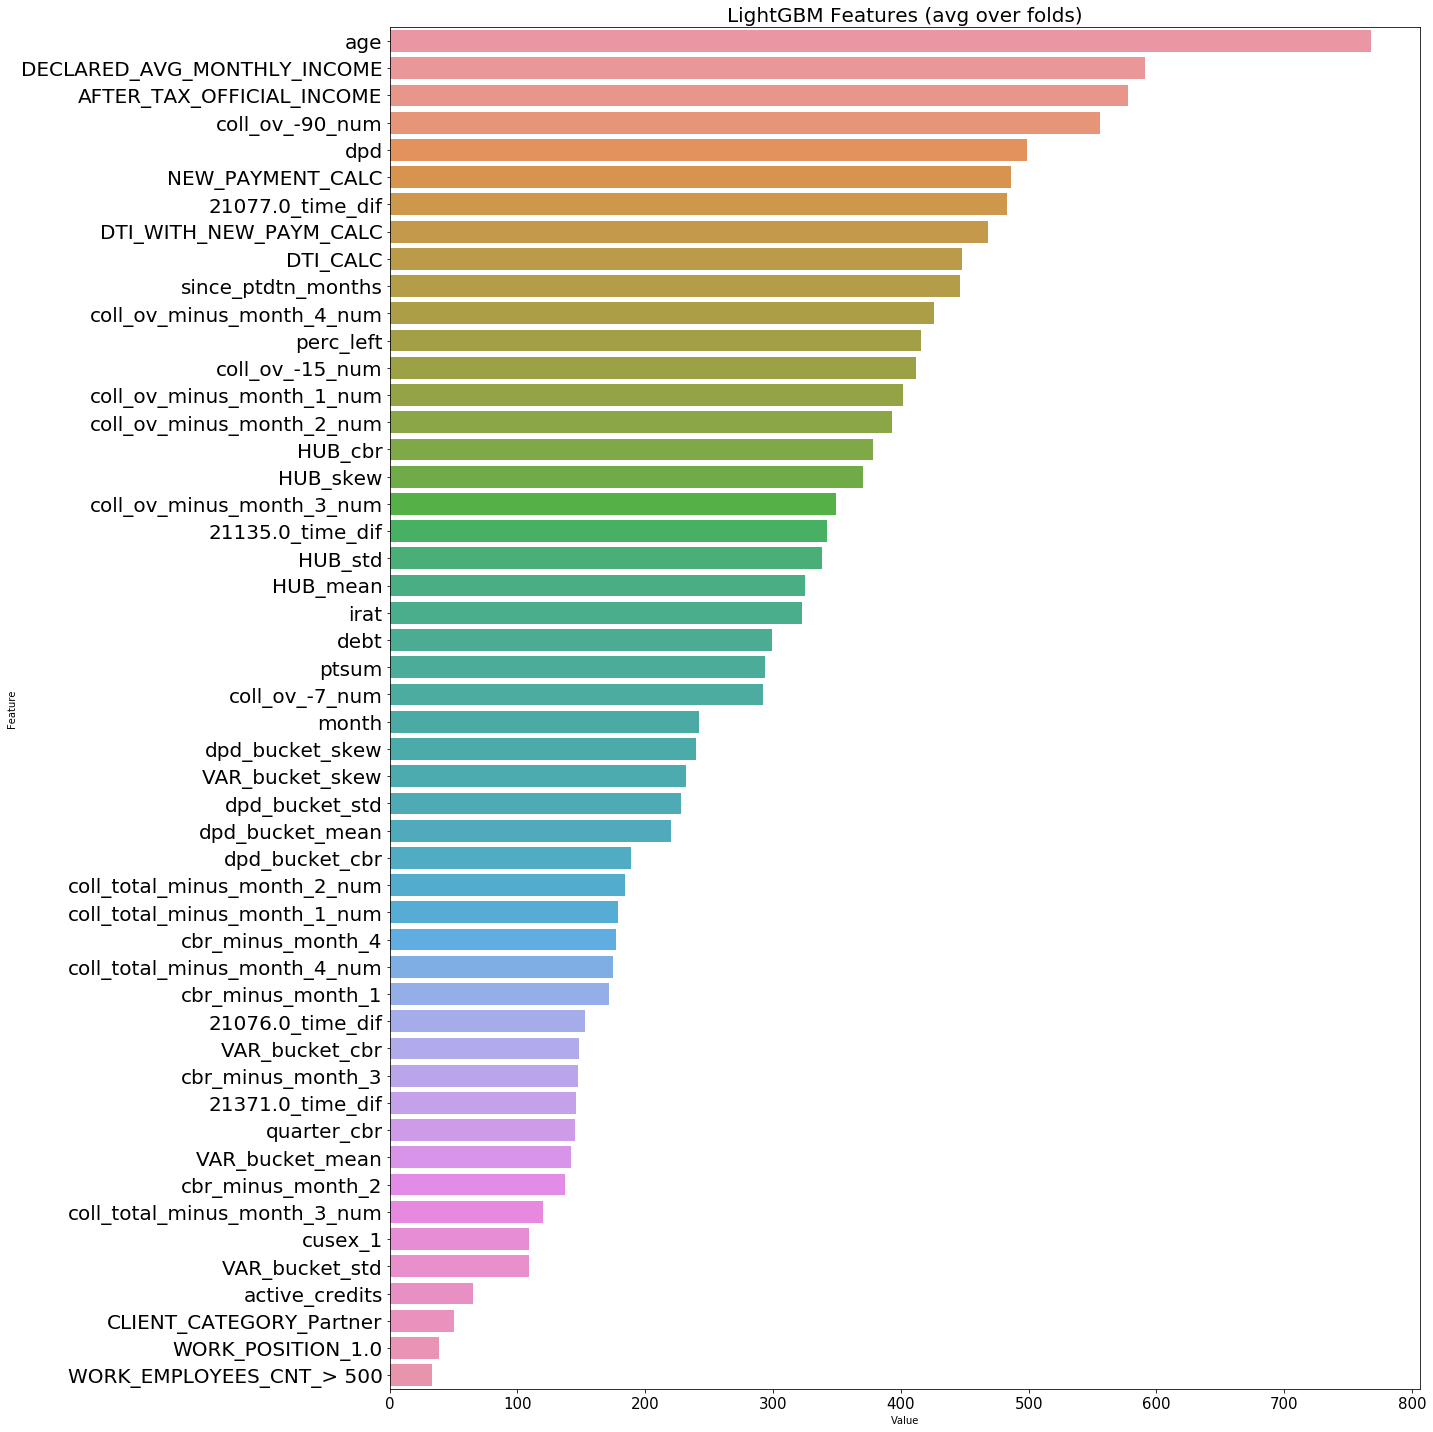

In [129]:
# выведем важные фичи для регрессии и классификации

feature_imp = pd.DataFrame(sorted(zip(fold_importance_df_cls.importance,fold_importance_df_cls.Feature))[:], columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50])
plt.title('LightGBM Features (avg over folds)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)

plt.tight_layout()
# plt.savefig("top50_features_cls.png")
plt.show()


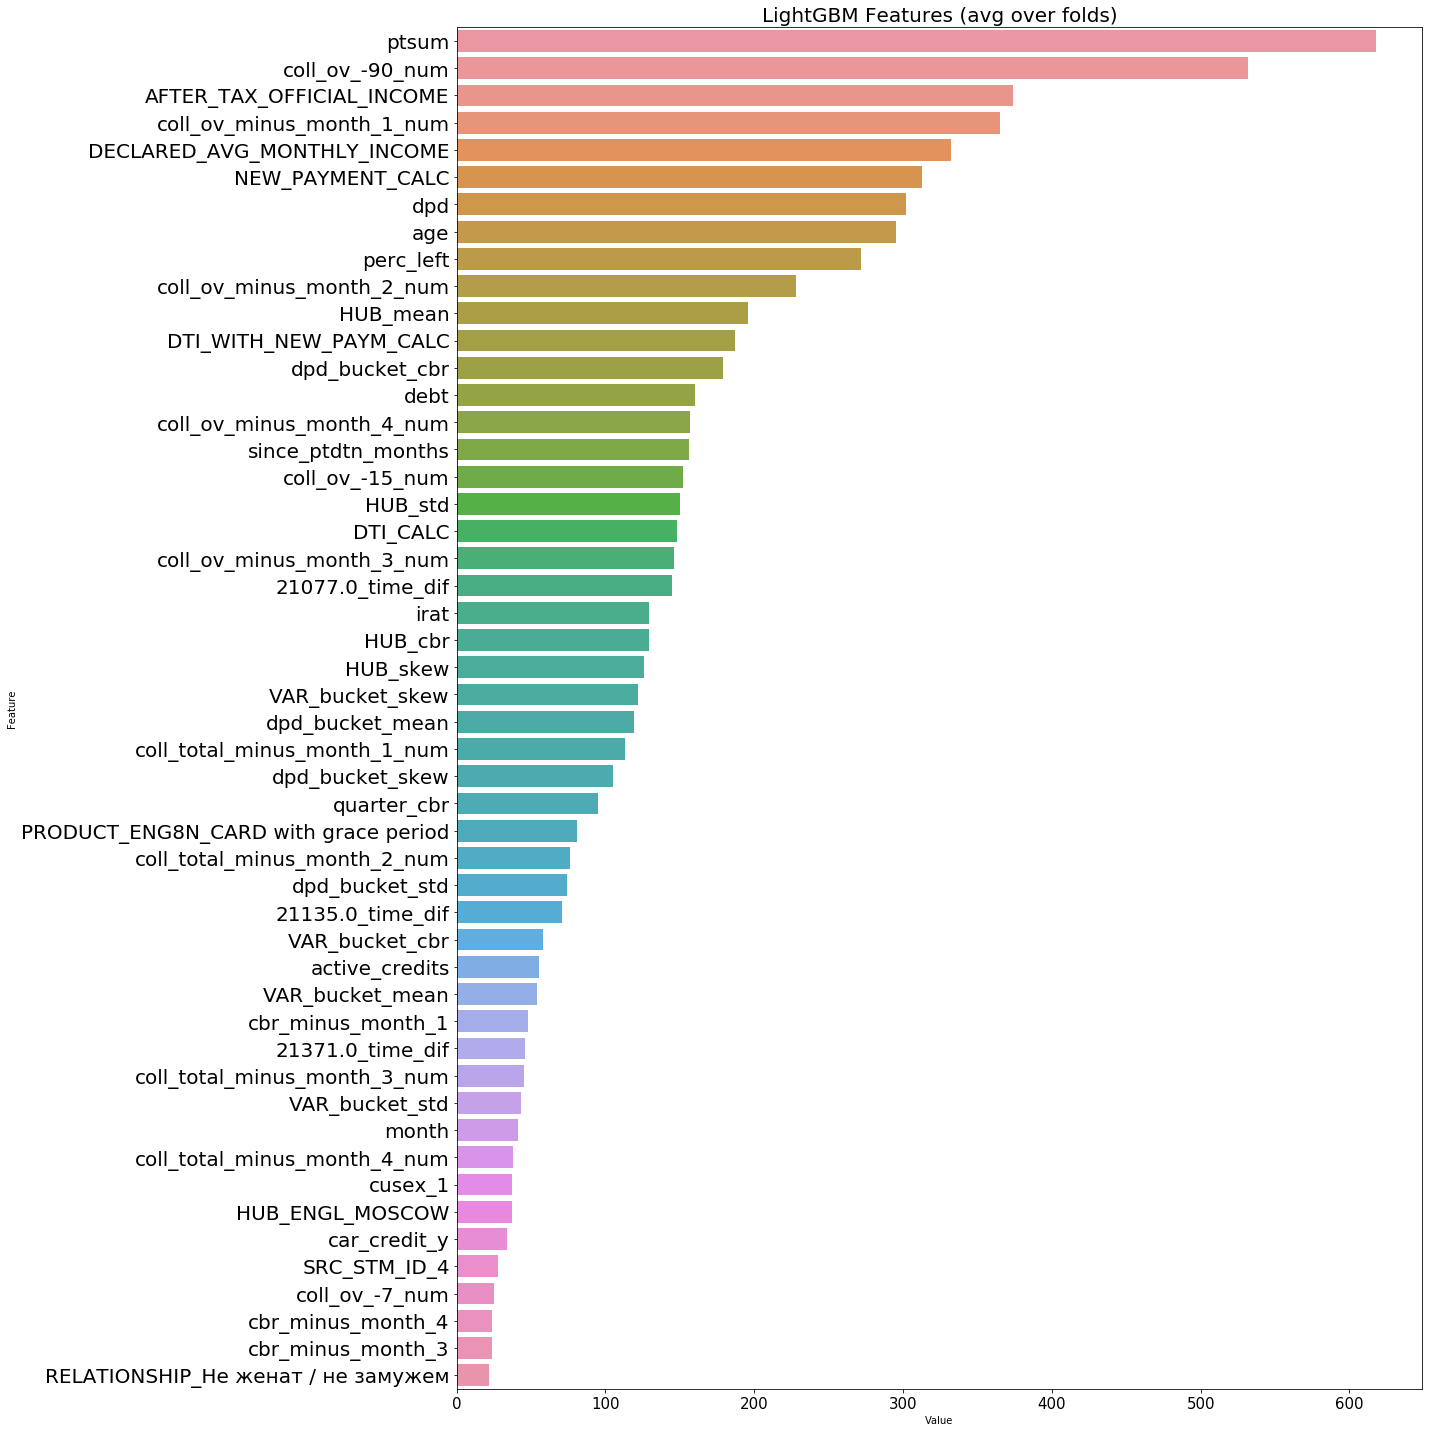

In [130]:
feature_imp = pd.DataFrame(sorted(zip(fold_importance_df_reg.importance,fold_importance_df_reg.Feature))[:], columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50])
plt.title('LightGBM Features (avg over folds)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("top50_features_reg.png")
plt.show()
